In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time
from lightgbm import LGBMRegressor
import seaborn as sns

In [3]:
# Descarga de data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right').mean()
len(data)

26304

In [4]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24 
             )

In [5]:
refits = [7, 14, 30]
refits = [False, True] + refits
results = []
metrics = []

for refit in refits:
    tic = time.perf_counter()

    metric, predictions = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = data['Demand'],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = 17482,
                            fixed_train_size      = False,
                            refit                 = refit,
                            verbose               = False,
                            show_progress         = False  
                        )

    toc = time.perf_counter()
    results.append(toc-tic)
    metrics.append(metric)

results = pd.DataFrame(
              data =  {'refit value': refits, 
                       'execution time (s)': results, 
                       'metric': metrics},
          )

results = results.sort_values(by=['seconds'])
results

c:\Users\jaesc2\GitHub\skforecast\skforecast\model_selection\model_selection.py:520: LongTrainingWarning: The forecaster will be fit 368 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\model_selection\model_selection.py:520: LongTrainingWarning: The forecaster will be fit 52 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


,refit_value,seconds,metric
0,False,1.355685,262.509329
4,30,3.995069,263.428653
3,14,6.337479,262.528465
2,7,11.080873,261.350947
1,True,69.145516,258.736184


In [6]:
print(results.to_markdown())

|    |   refit_value |   seconds |   metric |
|---:|--------------:|----------:|---------:|
|  0 |         False |   1.35568 |  262.509 |
|  4 |            30 |   3.99507 |  263.429 |
|  3 |            14 |   6.33748 |  262.528 |
|  2 |             7 |  11.0809  |  261.351 |
|  1 |          True |  69.1455  |  258.736 |


matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


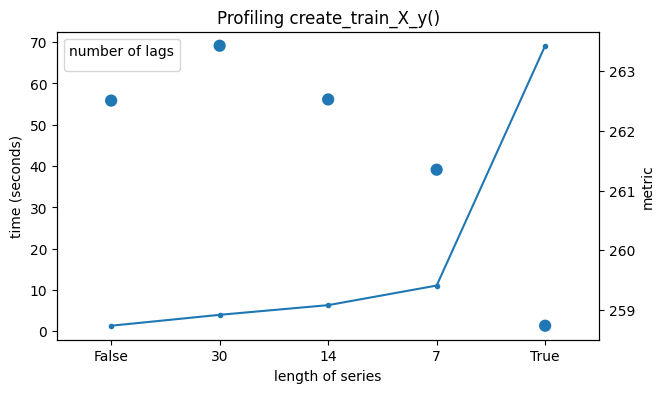

In [7]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(results['refit_value'].astype(str).to_numpy(), results['seconds'], marker='.')
ax2 =ax.twinx()
sns.pointplot(x=results['refit_value'].astype(str).to_numpy(), y=results['metric'], 
              join=False, ax=ax2)
# ax2.plot(results['refit_value'].astype(str).to_numpy(), results['metric'], marker='.')

ax.set_xlabel('length of series')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='number of lags');